**Install Miniconda, numpy and RDKit**

In [ ]:
%%capture
!pip install numpy
!wget -c https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.3-Linux-x86_64.sh
!time bash ./Miniconda3-py37_4.8.3-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit==2020.09.2 
!pip install scipy
!pip install lmfit

**Import Statements**

In [ ]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
import numpy as np
import matplotlib.pyplot as py
import rdkit
from rdkit import *
from rdkit.Chem import *
from rdkit.Chem.rdDistGeom import EmbedMultipleConfs
from rdkit.Chem.rdmolfiles import *
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import os
import scipy
from scipy import signal
from lmfit.models import LorentzianModel, QuadraticModel, LinearModel, PolynomialModel
import lmfit
from lmfit import Model

# **Algorithm**

In [ ]:
class Algorithm:  
  def __init__(self, theo_peaks, exp_peaks, cutoff = 0.01, u = 1100, h = 1800, sc = 1, algo = 1):
    """SPECTRUM INFORMATION"""
    print("Initialization ND")
    self.cutoff, self.theo_peaks, self.exp_peaks = cutoff, theo_peaks, exp_peaks
    self.algo, self.u, self.h, self.sc = algo, u, h, sc
    print("Initialization SUCCESSFUL")

  def Diagonal_IR(self, freq_i, inten_i, exp_freq_j, exp_inten_j, bond_l, bond_h,
                  n, m, exp_vcd = 0, inten_vcd = 0, width_j = 0, width_i = 0, eta_exp = 0, eta = 0):
    """COMPUTE THE SCORES FOR EACH PEAK COMBINATION DYNAMICALLY"""
    value = 2
    def sign(a):
      return bool(a > 0) - bool(a < 0)
    if self.algo == 0:
      if inten_vcd == exp_vcd:
        if min(abs(1-exp_freq_j/freq_i), abs(1-freq_i/exp_freq_j)) < self.cutoff and exp_freq_j > self.u and exp_freq_j < self.h:
          x_dummy = min(abs(1-exp_freq_j/freq_i), abs(1-freq_i/exp_freq_j))
          width_dummy = min(abs(1-width_j/width_i), abs(1-width_i/width_j))
          freq_contrib = np.exp(-1/(1-abs(x_dummy/self.cutoff)**2))
          y_dummy = min(abs(1-inten_i/exp_inten_j), abs(1-exp_inten_j/inten_i))
          inten_contrib = np.exp(-1/(1-abs(y_dummy/1)**2))
          sigma_contrib = np.exp(-1/(1-abs(width_dummy/8)**2))
          if min(abs(1-width_i/width_j), abs(1-width_j/width_i)) < 8:
            if abs(1-inten_i/exp_inten_j) < 1 or abs(1-exp_inten_j/inten_i) < 1:
              value = -inten_contrib*freq_contrib*sigma_contrib#*eta_contrib #scoring function 1

    if self.algo == 1:
      if inten_vcd == exp_vcd:
        if min(abs(1-exp_freq_j/freq_i), abs(1-freq_i/exp_freq_j)) < self.cutoff and exp_freq_j > self.u and exp_freq_j < self.h:
          inten_contrib = inten_i*exp_inten_j
          if min(abs(1-width_i/width_j), abs(1-width_j/width_i)) < 8:
            #if abs(inten_i-exp_inten_j) < 0.2:
            value = -inten_contrib#*eta_contrib #scoring function 1

    return value

  def Backtrace_IR(self, p_mat, al_mat, n, m, freq_i, inten_i, exp_freq_j,
                   exp_inten_i, sigma, bond_l, bond_h, exp_sigma, vcd, eta, eta_exp): #n theoretical, m experimental
    """BACKTRACE THE NEEDLEMAN ALGORITHM"""
    new_freq, new_freq_VCD, old_freq, new_inten, new_sigma = [], [], [], [], []
    new_eta, non_matched_sigma, new_inten_vcd, non_matched_freq = [], [], [], []
    matched_freq, vcd_ir_array, non_matched_inten, non_matched_inten_vcd = [], [], [], []
    n = n-1
    m = m-1
    current_scaling_factor = 1
    factors = []
    while True :
      if p_mat[n, m] == "D":
        new_freq.append(exp_freq_j[m-1])
        old_freq.append(freq_i[n-1])
        new_inten.append(inten_i[n-1])
        new_sigma.append(sigma[n-1])
        new_eta.append(eta[n-1])
        vcd_ir_array.append(vcd[n-1])
        current_scaling_factor = exp_freq_j[m-1]/freq_i[n-1]
        matched_freq.append(n-1)
        factors.append(current_scaling_factor)
        n = n-1
        m = m-1
      elif p_mat[n, m] == "V":
        non_matched_inten.append(n-1)
        non_matched_sigma.append(n-1)
        non_matched_inten_vcd.append(n-1)
        non_matched_freq.append(n-1)
        n = n-1
      elif p_mat[n, m] == "H":
        m = m-1
      else:
        break

    for i in range(len(non_matched_freq)):
      closest_distance = 9999
      matched_to = 0
      sf = 1
      for j in range(len(matched_freq)):
        dis = abs(freq_i[non_matched_freq[i]]-freq_i[matched_freq[j]])
        if(dis < closest_distance):
          closest_distance = dis
          sf = factors[j]
      new_freq.append(freq_i[non_matched_freq[i]]*sf)
      new_sigma.append(sigma[non_matched_sigma[i]])
      new_eta.append(eta[non_matched_sigma[i]])
      vcd_ir_array.append(vcd[non_matched_freq[i]])
      old_freq.append(freq_i[non_matched_freq[i]])
      new_inten.append(inten_i[non_matched_freq[i]])
      new_inten_vcd.append(0)
    return np.asarray(new_freq), np.asarray(new_inten), np.asarray(old_freq), np.asarray(new_sigma), np.asarray(new_eta), np.asarray(vcd_ir_array)
  
  def Pointer(self, di, ho, ve):
    """POINTER TO CELL IN THE TABLE"""
    pointer = min(di, min(ho, ve))
    if di == pointer:
      return "D"
    elif ho == pointer:
      return "H"
    else:
      return "V"

  def Needleman_IR(self):
    """NEEDLEMAN ALGORITHM FOR IR"""
    freq = self.theo_peaks[:, 1]*self.sc
    inten = self.theo_peaks[:, 0]
    sigma = self.theo_peaks[:, 2]
    vcd = self.theo_peaks[:, 3]
    try:
      eta = self.theo_peaks[:, 4]
    except:
      eta = np.ones((len(sigma)))
    exp_freq = self.exp_peaks[:, 1]
    exp_inten = self.exp_peaks[:, 0]
    exp_sigma = self.exp_peaks[:, 2]
    exp_inten_vcd = self.exp_peaks[:, 3]

    try:
      eta_exp = self.exp_peaks[:, 4]
    except:
      eta_exp = np.ones((len(exp_sigma)))

    bond_l = self.u
    bond_h = self.h
    n = len(freq)+1
    m = len(exp_freq)+1
    norm = 1
    al_mat = np.zeros((n, m))
    p_mat = np.zeros((n, m), dtype='U25') #string
    for i in range(1, n):
      al_mat[i, 0] = al_mat[i-1, 0]#+0.01#self.dummy_0 # BOUND SOLUTION, VALUE MIGHT BE CHANGED
      p_mat[i, 0] = 'V'
    for i in range(1, m):
      al_mat[0, i] = al_mat[0, i-1]#+0.01##+self.dummy_1
      p_mat[0, i] = 'H'
    p_mat[0, 0] = "S"
    normalize = 0
    for i in range(1, n): #theoretical
      for j in range(1, m): #experimental
        di = self.Diagonal_IR(freq[i-1], inten[i-1], exp_freq[j-1], exp_inten[j-1],
                              bond_l, bond_h, n, m, exp_vcd = exp_inten_vcd[j-1],
                              inten_vcd = vcd[i-1], width_j = exp_sigma[j-1],
                              width_i = sigma[i-1], eta_exp = eta_exp[j-1], eta = eta[i-1])
        di = al_mat[i-1, j-1]+di
        ho = al_mat[i, j-1]#+abs(exp_inten[j-1])#-np.sqrt((exp_inten[j-1]*self.cutoff*2)**2+exp_freq[j-1]**2)
        ve = al_mat[i-1, j]#+abs(inten[i-1])#-np.sqrt((exp_inten[j-1]*self.cutoff*2)**2+exp_freq[j-1]**2)
        al_mat[i, j] = min(di, min(ho, ve))
        p_mat[i, j] = self.Pointer(di, ho, ve)
    freq, inten, old_freq, new_sigma, eta_new, vcd = self.Backtrace_IR(p_mat, al_mat,
                                                                     n, m, freq, inten, exp_freq,
                                                                     exp_inten, sigma, bond_l, bond_h,
                                                                     exp_sigma, vcd=vcd, eta=eta, eta_exp = eta_exp)
    returnvalue = al_mat[n-1, m-1]#/(n+m) ##ORIGINALLY WE DIVIDED BY THE NUMBER OF THEORETICAL PEAKS
                                           ##HOWEVER, WE FOUND THIS TOO INCONVIENT, SINCE IT MAKES THE DEPENDENCE ON THE
                                           ##PURE NUMBERS TOO LARGE
    return returnvalue, old_freq, freq, inten, new_sigma, np.asarray(eta_new), np.asarray(vcd)

# **Function Declaration**

In [ ]:
def L_(x, amp, cen, wid):
  t = ((x-cen)/(wid/2))**2
  L = amp/(1+t)
  return L

def V_(x, amp, cen, wid, eta):
  t = ((x-cen)/(wid/2))**2
  G = 1*np.exp(-np.log(2)*t)
  L = 1/(1+t)
  V = amp*(eta*L+(1-eta)*G)
  return V

def add_peak(prefix, center, amplitude=0.5, sigma=12,eta=0.5):
  peak = Model(V_, prefix=prefix)
  pars = peak.make_params()
 
  pars[prefix+'cen'].set(center, min=center-2, max=center+2, vary=True)
  pars[prefix+'amp'].set(amplitude, vary=True, min=0.03, max=1.5)
  pars[prefix+'wid'].set(sigma, vary=True, min=1, max=64)
  pars[prefix+'eta'].set(eta, vary=True, min=0, max=1)
  return peak, pars


def Lorentzian_broadening(peaks, w = 6):
  p = np.arange(500, 2000)
  x = (p[:, np.newaxis] - (peaks[:, 0])[np.newaxis, :])/(w/2)
  L = (peaks[:, 1])[np.newaxis, :]/(1+x*x)
  y = np.sum(L, axis=-1)[:, np.newaxis]
  p = p[:, np.newaxis]
  spectrum = np.concatenate([p, y], axis=-1)
  return spectrum

def Voigt(freq, inten, new_sigma, new_eta, u=1000, h=1500):
  x = np.arange(u, h)
  list_append = []
  for i in range(len(freq)):
    t = ((x-freq[i])/(new_sigma[i]/2))**2
    L = inten[i]/(1+t)
    G = inten[i]*np.exp(-np.log(2)*t)
    list_append.append(L*new_eta[i]+(1-new_eta[i])*G)
  list_append = np.asarray(list_append)
  y = np.sum(list_append,axis=0)
  return x, y


def deconvolute(spectrum, peaks, working_dir = '/content/', save_data = 'ir_exp_peaks.txt', u = 1000, h = 2000):
  params, model, write_state, name_state = None, None, [], []
  model = None
  for i in range(0, len(peaks)):
    peak, pars = add_peak('lz%d_' % (i+1), center = peaks[i, 0], 
                          amplitude = peaks[i, 1])
    if(i == 0):
      model = peak
      params = model.make_params()
    else:
      model = model + peak
    params.update(pars)

  init = model.eval(params, x = spectrum[:, 0])
  result = model.fit(spectrum[:, 1], params, x = spectrum[:, 0])
  comps = result.eval_components()
  
  for name, par in result.params.items():
    write_state.append(par.value)

  write_state=np.asarray(write_state)
  write_state=write_state.reshape(-1,4)
  dic = lmfit.fit_report(result.params)
  py.plot(spectrum[:, 0], spectrum[:, 1], label = 'data', color = "black")
  py.plot(spectrum[:, 0], result.best_fit, label = 'best fit', color = "orange")
  py.xlim(h, u)
  py.ylim(0,1.02)
  py.show()
  f = open(working_dir+save_data, 'w')
  for i in write_state:
    f.write(str(i[0])+" "+str(i[1])+" "+str(i[2])+" 0 " +str(i[3])+"\n")
  f.close()


# **Global Settings**

In [ ]:
working_dir = '/content/'
##settings about the experimental spectrum
absorbance_ir = True ##Whether the absorbance of the exp spectrum is recorded
transmission_ir = False ##Whether the transmission of the exp spectrum is recorded
absorbance_raman = True ##Whether the absorbance of the exp spectrum is recorded
transmission_raman = False ##Whether the transmission of the exp spectrum is recorded
absorbance_vcd = True ##Whether the absorbance of the exp spectrum is recorded
transmission_vcd = False ##Whether the transmission of the exp spectrum is recorded

##Sampling settings
rmsd_cutoff = 0.5 ## choose either 0.5, 0.3 or 0.1
max_attempts = 10000 ## choose a large number
exp_torsion_preference = False ## set torsion preference to false
basic_knowledge = True ## set basic knowledge to True
ir = True ##Whether to compute IR spectra
raman = False ##Whether to compute Raman
u = 1000 ##lower limit
h = 1500 ##higher limit
vcd = False ##Whether to compute VCD (only possible with g09)
## Software to be used
orca_backend = True ## orca backend, use for IR and Raman
g09_backend = False ## gaussian backend, use for VCD
W = ' 4:00 ' ## Walltime
## Calculation setup orca/5.0.1
if(orca_backend):
  n_procs = ' 12 '
  mem = ' 1000 '
  basis_set = ' def2-TZVP def2/J '
  functional = ' RI BP86 D4 ' ## or use 'RIJCOSX B3LYP/G D4 '
  convergence = ' TightSCF TightOpt '
  if(raman):
    freq = " NumFreq "
  elif(ir):
    freq = " freq "
  else:
    freq = " "
elif(g09_backend):
## Calculation setup gaussian 09
  n_procs = ' 12 '
  mem = ' 12000 '
  basis_set = ' 6-31**G(d,p) '
  functional = ' B3LYP Dispersion=GD3 '
  convergence = ' TightSCF TightOpt '
  freq = ' freq('
  if(raman):
    freq+='Raman, ' 
  if(VCD):
    freq+='VCD, '
  freq+=')'
scaling_factor = 1.0 # change to 0.98 for B3LYP/G


# **WorkFlow, Step 1: Load experimental files**

**Load experimental files**

In [ ]:
from google.colab import files
uploaded = files.upload()
print(uploaded)
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
if(raman):
  uploaded = files.upload()
  print(uploaded)
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
if(vcd):
  uploaded = files.upload()
  print(uploaded)
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving IR_30.txt to IR_30.txt
{'IR_30.txt': b'4000.00 0.0175\n3999.75 0.0175\n3999.50 0.0175\n3999.25 0.0175\n3999.00 0.0175\n3998.75 0.0175\n3998.50 0.0175\n3998.25 0.0175\n3998.00 0.0175\n3997.75 0.0175\n3997.50 0.0175\n3997.25 0.0175\n3997.00 0.0175\n3996.75 0.0175\n3996.50 0.0176\n3996.25 0.0176\n3996.00 0.0176\n3995.75 0.0176\n3995.50 0.0176\n3995.25 0.0176\n3995.00 0.0176\n3994.75 0.0176\n3994.50 0.0176\n3994.25 0.0176\n3994.00 0.0176\n3993.75 0.0176\n3993.50 0.0176\n3993.25 0.0176\n3993.00 0.0176\n3992.75 0.0176\n3992.50 0.0176\n3992.25 0.0176\n3992.00 0.0176\n3991.75 0.0176\n3991.50 0.0176\n3991.25 0.0176\n3991.00 0.0176\n3990.75 0.0176\n3990.50 0.0176\n3990.25 0.0176\n3990.00 0.0176\n3989.75 0.0176\n3989.50 0.0176\n3989.25 0.0176\n3989.00 0.0176\n3988.75 0.0176\n3988.50 0.0176\n3988.25 0.0176\n3988.00 0.0176\n3987.75 0.0176\n3987.50 0.0176\n3987.25 0.0176\n3987.00 0.0176\n3986.75 0.0175\n3986.50 0.0175\n3986.25 0.0175\n3986.00 0.0175\n3985.75 0.0175\n3985.50 0.0175\n3985.25 0.

**Set path to experimenal Spectra**

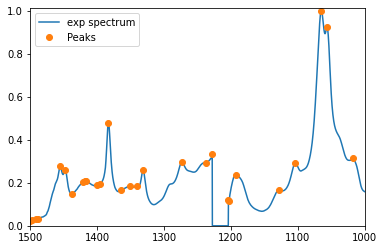

In [ ]:
path_to_exp_IR = '/content/IR_30.txt' ##We expect that the file has two columns:
                                      ## First column: x-coordinates
                                      ## Second column: y-coordinates
path_to_exp_raman = '/content/raman.txt'
path_to_exp_vcd = '/content/vcd.txt'
ir_exp = np.loadtxt(path_to_exp_IR, usecols=(0, 1))
if(not absorbance_ir):
  ir_exp[:, 1] = 2-np.log10(ir_exp[:, 1])
idx_ir_exp = (ir_exp[:, 0]>u) & (ir_exp[:, 0]<h)
ir_exp = ir_exp[idx_ir_exp]
ir_exp[:, 1] = ir_exp[:, 1]/np.max(ir_exp[:, 1])
py.plot(ir_exp[:, 0], ir_exp[:, 1], label='exp spectrum')
ind, _ = scipy.signal.find_peaks(ir_exp[:, 1])
ir_exp_peaks = ir_exp[ind]
py.plot(ir_exp_peaks[:, 0], ir_exp_peaks[:, 1], 'o' ,label='Peaks')
py.legend()
py.xlim(h, u)
py.ylim(0, 1.01)
py.show()
if(raman):
  raman_exp = np.loadtxt(path_to_exp_raman, usecols=(0, 1))
  if(not absorbance_raman):
    raman_exp[:, 1] = 2-np.log10(raman_exp[:, 1])
  idx_raman_exp = (raman_exp[:, 0] > u) & (raman_exp[:, 0] < h)
  py.plot(raman_exp[:, 0], raman_exp[:, 1]/np.max(raman_exp[idx_raman_exp, 1]))
  py.xlim(h, u)
  py.ylim(0, 1.01)
  py.show()
if(vcd):
  vcd_exp = np.loadtxt(path_to_exp_vcd, usecols=(0, 1))
  if(not absorbance_vcd):
    vcd_exp[:, 1] = 2-np.log10(vcd_exp[:, 1])
  idx_vcd_exp = (vcd_exp[:, 0] > u) & (vcd_exp[:, 0] < h)
  py.plot(vcd_exp[:, 0], vcd_exp[:, 1]/np.max(np.abs(vcd_exp[idx_vcd_exp, 1])))
  py.xlim(h, u)
  py.ylim(-1.01, 1.01)
  py.show()

**Deconvolute Experimental Spectra**

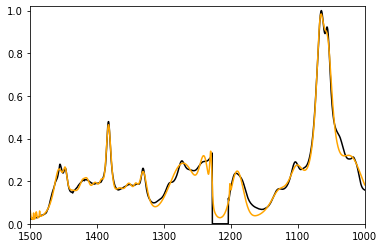

In [ ]:
deconvolute(ir_exp, ir_exp_peaks, working_dir=working_dir, save_data = 'ir_exp_peaks.txt', u = u, h = h)

# **WorkFlow, Step 2: Set Up Calculation Files**

**Set SMILE String**

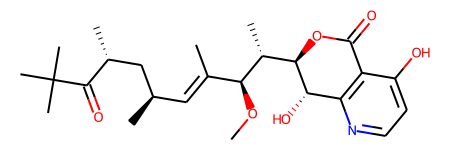

In [ ]:
#smile_string = 'C[C@H]([C@H]([C@H]([C@H](CO)Cl)O)Cl)Cl' ## Smile string of compound
smile_string = 'CC(C)(C)C(=O)[C@H](C)C[C@H](C)/C=C(\C)/[C@H](OC)[C@H](C)[C@H]1OC(=O)c2c([C@@H]1O)nccc2O'
mol = rdkit.Chem.MolFromSmiles(smile_string) ## Draw compound
mol

**Create Conformational Ensemble, Write to xyz files**



In [ ]:
solute_mol = AddHs(mol)
EmbedMultipleConfs(solute_mol, numConfs = max_attempts, clearConfs = True, 
                   pruneRmsThresh = rmsd_cutoff, numThreads = 8, 
                   useExpTorsionAnglePrefs = exp_torsion_preference,
                   useBasicKnowledge = basic_knowledge)
## Create calculation file
path = '/content/calculation_files/'
try:
  os.mkdir('/content/calculation_files')
except:
  print('folder already exists')
  pass
counter = 0

for i in range(max_attempts):
  try:
    rdkit.Chem.rdmolfiles.MolToXYZFile(solute_mol, 
                                           path+str(counter)+".xyz", confId = i)
    counter+=1
  except:
    pass
print("Number of conformations found", str(counter))
f = open(path+'out', 'w')
f.write(str(counter))
f.close()


Number of conformations found 10000


**Write Calculation files**

In [ ]:
if(orca_backend):
  f_submit = open(path+'job.sh', 'w')
  for i in range(counter):
    f = open(path+str(i)+".inp","w+")
    f.write("""! """ + functional + basis_set + convergence + freq + """
%maxcore """+ mem + """
%pal nprocs """ + n_procs + """
end
* xyzfile 0 1 """ +str(i)+""".xyz \n""")
    f.close()
    f_sh = open(path+str(i)+".sh", 'w')
    f_sh.write("""a=$PWD
cd $TMPDIR
cp ${a}/"""+str(i)+""".inp .
cp ${a}/"""+str(i)+""".xyz .
module load orca openmpi/4.0.2
sleep 20
/cluster/apps/nss/orca/5.0.1/x86_64/bin/orca """+str(i)+""".inp > """+str(i)+""".out
cp """+str(i)+""".out ${a}
cp """+str(i)+""".engrad ${a}
cp """+str(i)+""".hess ${a}
cp """+str(i)+""".xyz ${a}
cd ${a}""")
    f_sh.close()
    f_submit.write('chmod +wrx '+str(i)+'.sh\n')
    f_submit.write('bsub -n ' +n_procs + '-W '+W+' ./'+str(i)+'.sh\n')
  f_submit.close()

#elif(g09_backend):
#  continue

**ZIP Files**

In [ ]:
%%capture
import zipfile
from google.colab import drive
from google.colab import files
!zip -rm /content/input.zip /content/calculation_files

**Download**

In [ ]:
files.download("/content/input.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Next, you need to perform the calculations. The job.sh script automatically submits the jobs to the local cluster (i.e., bash job.sh), however, depending on your cluster architecture, you might need to update this file. You can then zip the calculation, i.e., zip -rm output.zip calculation_files, and upload it to the collab, and continue with the workflow

# **Workflow, Step 3: Align the Spectra**

**Upload finished computation**

In [ ]:
uploaded = files.upload()
print(uploaded)
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving 30_calc_out_250.zip to 30_calc_out_250.zip


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



**Unzip file**

In [ ]:
%%capture
!unzip /content/30_calc_out_250.zip

**Set Path to Calculation Setup**

In [ ]:
path_output = '/content/30_calc_out_250/'

**Read in free energies, IR spectra, and potentially other spectra**

In [ ]:
free_energies, energies, ir_spectra, structure_files = [], [], [], []

if(orca_backend):
  files = os.listdir(path_output)  
  for fi in files:
    if(fi.endswith('.out')):
      name = fi.split('.')[0]
      freq = np.zeros((400, 2))
      f = open(path_output+name+".out", 'r')
      imaginary = False
      free_energies_tmp = 0
      energies_tmp = 0
      for line in f:
        if('Final Gibbs free energy' in line):
          free_energies_tmp = float(line.split()[-2])
        elif('FINAL SINGLE POINT ENERGY' in line):
          energies_tmp = float(line.split()[-1])
        elif('IR SPECTRUM' in line):
          f.readline()
          f.readline()
          f.readline()
          f.readline()
          f.readline()
          counter_tmp = 0
          while(True):
            try:
              tmp = f.readline().split()
              freq[counter_tmp, 0] = float(tmp[1])
              freq[counter_tmp, 1] = float(tmp[3])
              if(float(tmp[1]) < 0):
                imaginary = True
            except:
              break
            counter_tmp+=1
      if(imaginary==False and free_energies_tmp!=0 and energies_tmp!=0):
        structure_files.append(int(name))
        ir_spectra.append(freq)
        energies.append(energies_tmp)
        free_energies.append(free_energies_tmp)

free_energies = np.asarray(free_energies)
energies = np.asarray(energies)
ir_spectra = np.asarray(ir_spectra)
structure_files = np.asarray(structure_files)
print(len(energies))
print(len(free_energies))
print(len(structure_files))

238
238
238


**Filter structures which are equivalent**

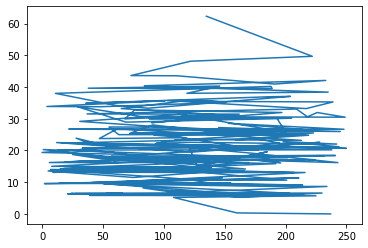

In [ ]:
threshold = 1e5 ## corresponds to 0.026 kJmol
hartree_to_kJmol = 2625.4996394799
_, index = np.unique(np.asarray(energies*threshold, dtype=int), return_index=True)
free_energies = free_energies[index]*hartree_to_kJmol
energies = energies[index]*hartree_to_kJmol
ir_spectra = ir_spectra[index]
structure_files = structure_files[index]
free_energies-=np.min(free_energies)
energies-=np.min(energies)
py.plot(structure_files, free_energies)
py.show()

**Generate Superimposed IR spectrum**

1.0


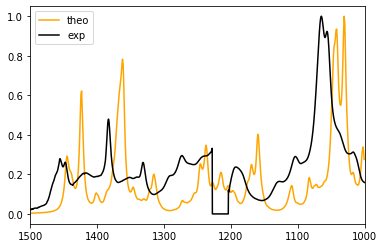

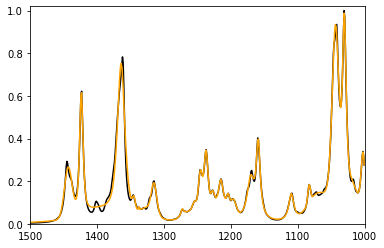

In [ ]:
lorentzian_bandwidth = np.arange(6, 7, 1)
Z = 1
print(scaling_factor)
RT = 0.008314*298.15 # in kJmol
ir_theo_data = ir_spectra[0]
if(len(free_energies) > 0):
  Z = np.sum(np.exp(-free_energies/RT))
  ir_theo_y = (ir_spectra[:, :, 1]*np.exp(-free_energies[:, np.newaxis]/RT)/Z).flatten()
  ir_theo_x = ir_spectra[:, :, 0].flatten()
  ir_theo_data = np.concatenate([ir_theo_x[:, np.newaxis], ir_theo_y[:, np.newaxis]], axis=-1)
for w in lorentzian_bandwidth:
  ir_theo = Lorentzian_broadening(ir_theo_data, w = w)
  idx_ir_theo = (ir_theo[:, 0] > u) & (ir_theo[:, 0] < h)
  ir_theo = ir_theo[idx_ir_theo]
  ir_theo[:, 1] /= np.max(ir_theo[:, 1])
  ind, _ = scipy.signal.find_peaks(ir_theo[:, 1])
  py.plot(ir_theo[:, 0]*scaling_factor, ir_theo[:, 1], label = "theo", color = 'orange')
  py.plot(ir_exp[:, 0], ir_exp[:, 1], label = "exp", color = 'black')
  py.legend()
  py.xlim(h, u)
  py.show()
  deconvolute(ir_theo, ir_theo[ind], working_dir = '/content/', save_data = str(w)+'_ir_theo_peaks.txt', u = u, h = h)

**Print out Parameters**

In [ ]:
#for w in lorentzian_bandwidth:
#  print(np.loadtxt(working_dir+str(w)+"_ir_theo_peaks.txt"))

Initialization ND
Initialization SUCCESSFUL
1.0 -1.0713489501758149


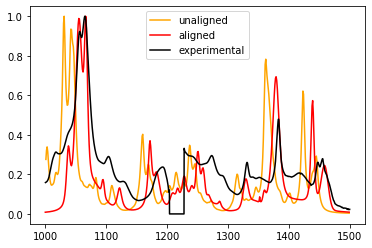

Initialization ND
Initialization SUCCESSFUL
1.005 -1.0713489501758149


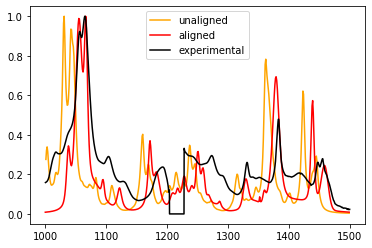

Initialization ND
Initialization SUCCESSFUL
1.0099999999999998 -1.0713489501758149


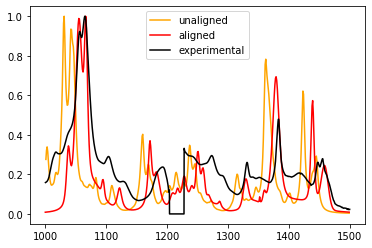

Initialization ND
Initialization SUCCESSFUL
1.0149999999999997 -1.0713489501758149


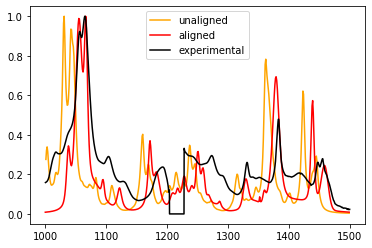

Initialization ND
Initialization SUCCESSFUL
1.0199999999999996 -1.0713489501758149


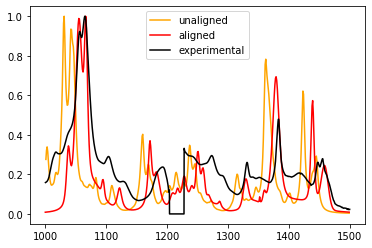

In [ ]:
scaling_factor = np.arange(1.000, 1.02, 0.005)
for sc in scaling_factor:
  algorithm = Algorithm(theo_peaks = np.loadtxt(working_dir+str(w)+"_ir_theo_peaks.txt"), 
          exp_peaks = np.loadtxt(working_dir+"ir_exp_peaks.txt"),
          cutoff = 0.04, u = u, h = h, sc = sc)
  s, _, freq_aligned, inten_aligned, sigma, eta, vcd_ir_array = algorithm.Needleman_IR()
  vcd_ir_array = np.asarray(vcd_ir_array, dtype=int)

  x, y = Voigt(freq_aligned[vcd_ir_array == 0], inten_aligned[vcd_ir_array == 0], 
           sigma[vcd_ir_array == 0], 
           eta[vcd_ir_array == 0], u = u, h = h)
  y /= np.max(y) 
  py.plot(ir_theo[:, 0], ir_theo[:, 1], label = "unaligned", color = 'orange')
  py.plot(x, y, label = "aligned", color = 'red')
  py.plot(ir_exp[:, 0], ir_exp[:, 1], label = "experimental", color = 'black')
  print(sc, s)
  py.legend()
  py.show()